# Backpropagation
Simple implementation and explanation of backward propagation using linear layers with some simple activation functions that I did when studying this initially.

Backpropagation computes the gradients of the parameters in a computational graph. Backpropagation is the chain rule of differentiation where we are able to reuse computed partial differentials by stepping backwards.

In [1]:
import numpy as np
from sklearn.datasets import make_gaussian_quantiles
import matplotlib.pyplot as plt

## Activation functions

In [2]:
def sigmoid(z):
    return 1.0 / (1. + np.exp(-z))

def d_sigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))

def sigmoid_backwards(a):
    return a * (1 - a)

SIGMOID_ACTIVATION = (sigmoid, sigmoid_backwards)

"""
def tanh(z):
    return np.tanh(z)

def d_tanh(z):
    pass

TANH_ACTIVATION = (tanh, d_tanh)
"""

def relu(z):
    return np.max(0, z)

def d_relu(z):
    return 1.0 * (z > 0)

RELU_ACTIVATION = (relu, d_relu)

## Backpropagation implementation

In [15]:
def init_parameters(layer_shapes):
    """Create initial random parameters."""
    parameters = {}
    for i, shape in enumerate(layer_shapes):
        parameters["W{}".format(i+1)] = np.random.randn(*shape) * 0.01
        parameters["b{}".format(i+1)] = np.zeros((1, shape[1]))
    return parameters
        
def forward(X, parameters, activation_fns):
    """Compute the activations at each layer."""
    A = X
    activations = [X]
    for i, (activation_fn, _) in enumerate(activation_fns):
        W = parameters["W{}".format(i+1)]
        b = parameters["b{}".format(i+1)]
        A = activation_fn(A @ W + b)
        activations.append(A)
    return activations

def backward(parameters, activation_fns, activations, dA_loss):
    """Compute gradients for all parameters."""
    gradients = {}
    dA = dA_loss
    for l in reversed(range(1, len(activations))):
        W = parameters["W{}".format(l)]
        b = parameters["b{}".format(l)]
        A = activations[l]
        m = A.shape[0]
        A_prev = activations[l-1]
        _, diff_activation_fn = activation_fns[l-1]  # TODO: Make this consistent with naming of parameters.
        dZ = dA * diff_activation_fn(A)
        dW = (1 / m ) * A_prev.T @ dZ
        db = np.mean(dZ, axis=0, keepdims=True)
        gradients["W{}".format(l)] = dW
        gradients["b{}".format(l)] = db
        dA = dZ @ W.T
    return gradients
    
def update(parameters, gradients, learning_rate):
    """Compute the next set of parameters given the gradients and learning rate."""
    return {k: v - learning_rate * gradients[k] for k, v in parameters.items()}

## Model example: binary classifier

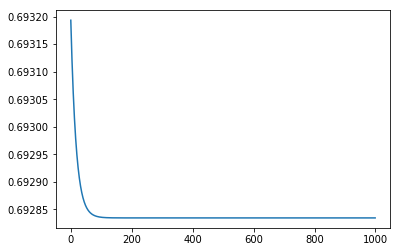

0.45


In [38]:
def binary_classifier(X_train, Y_train, X_test, Y_test, learning_rate, train_steps):
    input_dim = X.shape[1]
    layer_shapes = [(input_dim, 10), (10, 5), (5, 1)]
    activation_fns = [SIGMOID_ACTIVATION, SIGMOID_ACTIVATION, SIGMOID_ACTIVATION]
    assert len(layer_shapes) == len(activation_fns)
    
    parameters = init_parameters(layer_shapes)
    
    def cross_entropy_loss(A, Y):
        """Compute the cross entropy loss."""
        m = A.shape[0]
        return (-(1 / m) * (np.log(A).T @ Y + np.log(1 - A).T @ (1 - Y))).squeeze()
    
    # TODO: numerical issues with this?
    def d_cross_entropy_loss(A, Y):
        """Compute the derivative of the cross entropy loss w.r.t. the net's output."""
        m = A.shape[0]
        return -Y / A + (1 - Y) / (1 - A)
    
    # Train the network.
    losses = np.zeros(train_steps)
    for i in range(train_steps):
        activations = forward(X_train, parameters, activation_fns)
        A = activations[-1]
        losses[i] = cross_entropy_loss(A, Y_train)
        dA_loss = d_cross_entropy_loss(A, Y_train)
        gradients = backward(parameters, activation_fns, activations, dA_loss)
        parameters = update(parameters, gradients, learning_rate)
    
    def predict(X):
        """Closure to predict with the trained network."""
        activations = forward(X, parameters, activation_fns)
        output = activations[-1]
        return output > 0.5
    
    return predict, losses

N = 1000
X, Y = make_gaussian_quantiles(n_classes=2, n_features=2, n_samples=N)
Y = Y[:, np.newaxis]
split_idx = int(0.8 * N)
X_train = X[:split_idx]
Y_train = Y[:split_idx]
X_test = X[split_idx:]
Y_test = Y[split_idx:]

predict, losses = binary_classifier(X_train,
                                    Y_train,
                                    X_test,
                                    Y_test,
                                    learning_rate=0.05,
                                    train_steps=1000)

plt.plot(losses)
plt.show()
Y_pred = predict(X_test)
accuracy = (Y_pred.astype(int) == Y_test).mean()
print(accuracy)

In [20]:
X = None
Y = None
# TODO train/test set

binary_classifier_predict = binary_classifier(X_train, Y_train)

TypeError: binary_classifier() missing 4 required positional arguments: 'X_test', 'Y_test', 'learning_rate', and 'train_steps'